In [1]:
!pip install -q transformers
!pip install -q datasets
!pip install -q torch
!pip install -q evaluate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12=

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import json
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import AlbertTokenizer, AlbertForSequenceClassification, AlbertForQuestionAnswering
from datasets import load_dataset
from datasets import Dataset
from transformers import TrainingArguments, Trainer
import torch
from sklearn.model_selection import StratifiedKFold
import os
import evaluate
from sklearn.utils.class_weight import compute_class_weight
from transformers.utils import logging

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# load both datasets, merge, and split data into test set
df1 = pd.read_csv('./drive/MyDrive/w266/labeled_data.csv')
df2 = pd.read_csv('./drive/MyDrive/w266/labeled_data_npr_sampled.csv')

df1=df1[['question', 'response', 'label']]
df2=df2[['question', 'response', 'label']]

df= pd.concat([df1, df2], ignore_index=True)

train_val_df, test_df = train_test_split(df, test_size=0.15, random_state=42, stratify=df["label"])
train_df, val_df = train_test_split(train_val_df, test_size=0.15, random_state=42, stratify=train_val_df["label"])

train_df.to_json("train.json", orient="records", lines=True)
val_df.to_json("val.json", orient="records", lines=True)
test_df.to_json("test.json", orient="records", lines=True)

print(f"Training set: {len(train_df)} samples")
print(f"Validation set: {len(val_df)} samples")
print(f"Test set: {len(test_df)} samples")

Training set: 14780 samples
Validation set: 2609 samples
Test set: 3069 samples


In [8]:
# load ALBERT tokenizer and qa model trained on CoQA
tokenizer = AlbertTokenizer.from_pretrained("./drive/MyDrive/w266/model_checkpoints/albert_coqa_qnli")
model = AlbertForSequenceClassification.from_pretrained("./drive/MyDrive/w266/model_checkpoints/albert_coqa_qnli")



In [9]:
# set up for training
def preprocess_function(examples):
    return tokenizer(examples["question"], examples["response"], truncation=True, padding="max_length", max_length=512)

train_labels = train_df["label"].tolist()
val_labels = val_df["label"].tolist()
# train_labels_balanced = train_df_balanced["label"].tolist()


In [10]:
# weight classes due to imbalanced data set
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}

class_weights_tensor = torch.tensor(list(class_weights.values())).float().to(device)

print(class_weights)


{0: np.float64(0.5158453162082927), 1: np.float64(16.277533039647576)}


In [11]:
# add evaluation measures
accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")

f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)

    return {
        "accuracy": accuracy_metric.compute(predictions=predictions, references=labels)["accuracy"],
        "precision": precision_metric.compute(predictions=predictions, references=labels, average="binary")["precision"],
        "recall": recall_metric.compute(predictions=predictions, references=labels, average="binary")["recall"],
        "f1": f1_metric.compute(predictions=predictions, references=labels, average="binary")["f1"]
    }

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [12]:
class_weights_tensor = torch.tensor([0.005, 200.0]).float().to(device)


In [13]:
# create trainer class for weighted training
class WeightedTrainer(Trainer):
  def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
          labels = inputs.get("labels")
          outputs = model(**inputs)
          logits = outputs.logits

          loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights_tensor.to(device), reduction='sum')
          loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))

          return (loss, outputs) if return_outputs else loss

In [14]:
train_dataset = Dataset.from_pandas(train_df).map(preprocess_function, batched=True)
val_dataset = Dataset.from_pandas(val_df).map(preprocess_function, batched=True)


Map:   0%|          | 0/14780 [00:00<?, ? examples/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Map:   0%|          | 0/2609 [00:00<?, ? examples/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

In [15]:
training_args = TrainingArguments(
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16,
    num_train_epochs=4,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1",
    greater_is_better=True,
    report_to="none"
)

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

logging.set_verbosity_error()

trainer.train()

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-15-eeeec10ecf0d>:13: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,158.131800,60.268242,0.894212,0.101626,0.312500,0.153374
2,167.902200,83.742073,0.969337,0.000000,0.000000,0.000000
3,156.724800,73.714287,0.968570,0.250000,0.012500,0.023810
4,145.562900,82.006248,0.966271,0.250000,0.050000,0.083333


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TrainOutput(global_step=3696, training_loss=158.59951214150433, metrics={'train_runtime': 6278.6598, 'train_samples_per_second': 9.416, 'train_steps_per_second': 0.589, 'total_flos': 1412855776051200.0, 'train_loss': 158.59951214150433, 'epoch': 4.0})

In [16]:
# check misclassified examples
val_preds_output = trainer.predict(val_dataset)
val_logits = val_preds_output.predictions
val_preds = np.argmax(val_logits, axis=-1)
val_labels = val_preds_output.label_ids

val_df = pd.DataFrame({"Actual": val_labels, "Predicted": val_preds})

val_misclassified = val_df[val_df["Actual"] != val_df["Predicted"]]
print(f"\nValidation Misclassified Examples:\n{val_misclassified}")




Validation Misclassified Examples:
      Actual  Predicted
6          0          1
16         0          1
19         0          1
22         1          0
23         0          1
...      ...        ...
2563       0          1
2577       0          1
2587       0          1
2590       0          1
2601       0          1

[276 rows x 2 columns]


In [17]:
val_df[val_df["Actual"]==1]

,Actual,Predicted
22,1,0
79,1,0
95,1,0
182,1,0
190,1,0
...,...,...
2471,1,0
2480,1,0
2507,1,0
2540,1,0


In [18]:
val_df[val_df["Predicted"]==1]

,Actual,Predicted
6,0,1
16,0,1
19,0,1
23,0,1
63,0,1
...,...,...
2577,0,1
2587,0,1
2590,0,1
2601,0,1


In [19]:
model.save_pretrained('./drive/MyDrive/w266/model_checkpoints/A_C_Q_npr2', from_pt=True)
tokenizer.save_pretrained('./drive/MyDrive/w266/model_checkpoints/A_C_Q_npr2', from_pt=True)


('./drive/MyDrive/w266/model_checkpoints/A_C_Q_npr2/tokenizer_config.json',
 './drive/MyDrive/w266/model_checkpoints/A_C_Q_npr2/special_tokens_map.json',
 './drive/MyDrive/w266/model_checkpoints/A_C_Q_npr2/spiece.model',
 './drive/MyDrive/w266/model_checkpoints/A_C_Q_npr2/added_tokens.json')

In [21]:
test_dataset = Dataset.from_pandas(test_df)

In [23]:
def predict(example):
    encoding = tokenizer(example['question'], example['response'],
                         truncation=True, padding="max_length", max_length=512, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model(**encoding)
        logits = outputs.logits
        predicted_class = torch.argmax(logits, dim=-1).item()
    return predicted_class

test_predictions = [predict(example) for example in test_dataset]

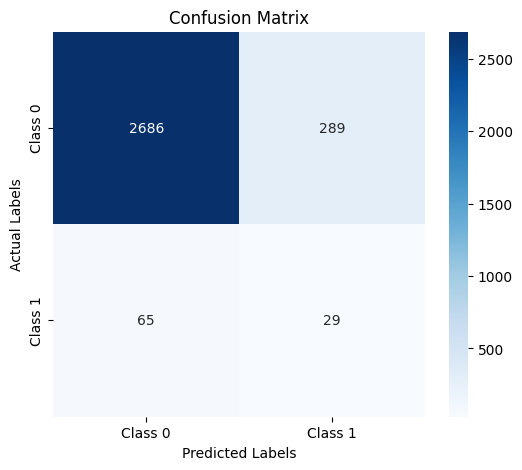

In [24]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

labels = test_df['label'].to_list()

cm = confusion_matrix(labels, test_predictions)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()


In [27]:
# check examples labeled as 1
test_df[test_df['label']==1]

,question,response,label
15837,I think many people would look at the poll num...,"Well, we're not giving up family reunification...",1
7693,Let's get another caller on the line and let's...,Hello?,1
12870,"Um-hum. Well, guess what's not jumping out?",(Soundbite of laughter),1
17259,"Uri, what's going on? Why the drop?","Good morning. Well, there are a lot of things ...",1
4935,"And the Mahdi Army, of course, the - again, th...","Absolutely, absolutely. And there's a lot of ...",1
...,...,...,...
7784,"And Christine, how do you watch WEG?",How do - I'm sorry?,1
16607,Well talk with John(ph). John is calling us fr...,Hello.,1
203,"If you’re mayor today, they withdrew money out...","I’m sorry, so—",1
20146,And how would you change the law then? What wo...,Well…,1


In [28]:
test_df[test_df['label']==1].to_csv('./drive/MyDrive/w266/model_checkpoints/labeled_1_2.csv')

In [26]:
# check examples predicted as 1
mask = np.array(test_predictions)
test_df.loc[mask==1]

,question,response,label
6391,This is your home and we're in the hallway of ...,Four.,0
1586,"Oh, that's great. How long have you been playi...","Oh, postcard days.",0
9424,You were once sent to try and find Dr. Sam She...,(Soundbite of laughter),0
2067,"...to the good, right?",So I hope (laughter).,0
19267,"Now, we actually, I think, try to get a hold o...",You did.,0
...,...,...,...
15033,"Jolene, what are you most looking forward to s...",Well...,0
4985,"Hi, Sister Mary Beth. How are you?","I'm doing fine, thank you. A little hot but do...",0
19362,So they can be more skeptical to you than they...,Absolutely.,0
20146,And how would you change the law then? What wo...,Well…,1


In [29]:
test_df.loc[mask==1].to_csv('./drive/MyDrive/w266/model_checkpoints/pred_1_2.csv')

Experiment with freezing different layers

In [31]:
# load ALBERT tokenizer and qa model trained on CoQA
tokenizer = AlbertTokenizer.from_pretrained("./drive/MyDrive/w266/model_checkpoints/albert_coqa_qnli")
model = AlbertForSequenceClassification.from_pretrained("./drive/MyDrive/w266/model_checkpoints/albert_coqa_qnli")


In [32]:
model.to(device)

AlbertForSequenceClassification(
  (albert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(30000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertSdpaAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=

In [33]:
for name, param in model.named_parameters():
    param.requires_grad = False
    if "albert.pooler" in name:
        param.requires_grad = True
    if "classifier" in name:
        param.requires_grad = True

In [34]:
class_weights_tensor = torch.tensor([0.005, 200.0]).float().to(device)

In [35]:
for name, param in model.named_parameters():
    print(name, param.requires_grad)

albert.embeddings.word_embeddings.weight False
albert.embeddings.position_embeddings.weight False
albert.embeddings.token_type_embeddings.weight False
albert.embeddings.LayerNorm.weight False
albert.embeddings.LayerNorm.bias False
albert.encoder.embedding_hidden_mapping_in.weight False
albert.encoder.embedding_hidden_mapping_in.bias False
albert.encoder.albert_layer_groups.0.albert_layers.0.full_layer_layer_norm.weight False
albert.encoder.albert_layer_groups.0.albert_layers.0.full_layer_layer_norm.bias False
albert.encoder.albert_layer_groups.0.albert_layers.0.attention.query.weight False
albert.encoder.albert_layer_groups.0.albert_layers.0.attention.query.bias False
albert.encoder.albert_layer_groups.0.albert_layers.0.attention.key.weight False
albert.encoder.albert_layer_groups.0.albert_layers.0.attention.key.bias False
albert.encoder.albert_layer_groups.0.albert_layers.0.attention.value.weight False
albert.encoder.albert_layer_groups.0.albert_layers.0.attention.value.bias False
alb

In [37]:
training_args = TrainingArguments(
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1",
    greater_is_better=True,
    report_to="none"
)

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

logging.set_verbosity_error()

trainer.train()

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-37-08e63f56c864>:14: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


{'loss': 134.7301, 'grad_norm': 0.4440155327320099, 'learning_rate': 4.323593073593074e-05, 'epoch': 0.5411255411255411}
{'eval_loss': 140.18212890625, 'eval_accuracy': 0.9655040245304715, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_runtime': 92.839, 'eval_samples_per_second': 28.102, 'eval_steps_per_second': 1.766, 'epoch': 1.0}
{'loss': 151.8898, 'grad_norm': 7448.2685546875, 'learning_rate': 3.6471861471861474e-05, 'epoch': 1.0822510822510822}
{'loss': 150.1043, 'grad_norm': 0.47361740469932556, 'learning_rate': 2.9707792207792207e-05, 'epoch': 1.6233766233766234}
{'eval_loss': 152.75193786621094, 'eval_accuracy': 0.9632042928325029, 'eval_precision': 0.05555555555555555, 'eval_recall': 0.0125, 'eval_f1': 0.02040816326530612, 'eval_runtime': 92.9167, 'eval_samples_per_second': 28.079, 'eval_steps_per_second': 1.765, 'epoch': 2.0}
{'loss': 143.6842, 'grad_norm': 6030.7705078125, 'learning_rate': 2.2943722943722946e-05, 'epoch': 2.1645021645021645}
{'loss': 144.05

TrainOutput(global_step=3696, training_loss=144.6066609172078, metrics={'train_runtime': 2482.7071, 'train_samples_per_second': 23.813, 'train_steps_per_second': 1.489, 'train_loss': 144.6066609172078, 'epoch': 4.0})

In [38]:
model.save_pretrained('./drive/MyDrive/w266/model_checkpoints/A_C_Q_npr3', from_pt=True)
tokenizer.save_pretrained('./drive/MyDrive/w266/model_checkpoints/A_C_Q_npr3', from_pt=True)

('./drive/MyDrive/w266/model_checkpoints/A_C_Q_npr3/tokenizer_config.json',
 './drive/MyDrive/w266/model_checkpoints/A_C_Q_npr3/special_tokens_map.json',
 './drive/MyDrive/w266/model_checkpoints/A_C_Q_npr3/spiece.model',
 './drive/MyDrive/w266/model_checkpoints/A_C_Q_npr3/added_tokens.json')